<a href="https://colab.research.google.com/github/K-nowing/AudioDVP/blob/master/23W_06%2C07_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LG-고려대 AI Workshop
# 2023 Winter
--------------------------------------------
## Lab 6-7. Object Detection
<p style='font-size:20px'><font color = gray> Injae Kim (dna9041@korea.ac.kr)</font></p>

In [ ]:
# 다운 받아 쓸 library & data가 많아 폴더 생성해서 관리

import os 
from os.path import join

path = os.getcwd() + "/MOT/"
!mkdir "{path}"



---


**1. Dataset**


*   https://motchallenge.net/ : MOT17Det Dataset for Pedestrian Detection Challenge
*   MOT17-09 dataset 만 쓸 예정입니다!


---






In [ ]:
!wget -P "{path}" https://motchallenge.net/data/MOT17Det.zip

In [ ]:
!cd "{path}";unzip MOT17Det.zip

In [ ]:
import sys

motdata = join(path,'train/MOT17-09/img1/')
motdata2 = join(path,'train/MOT17-02/img1/')
motdata3 = join(path,'train/MOT17-04/img1/')
motdata4 = join(path,'train/MOT17-05/img1/')
motdata5 = join(path,'train/MOT17-10/img1/')
motdata6 = join(path,'train/MOT17-11/img1/')
motdata7 = join(path,'train/MOT17-13/img1/')

sys.path.append(motdata)
sys.path.append(motdata2)
sys.path.append(motdata3)
sys.path.append(motdata4)
sys.path.append(motdata5)
sys.path.append(motdata6)
sys.path.append(motdata7)

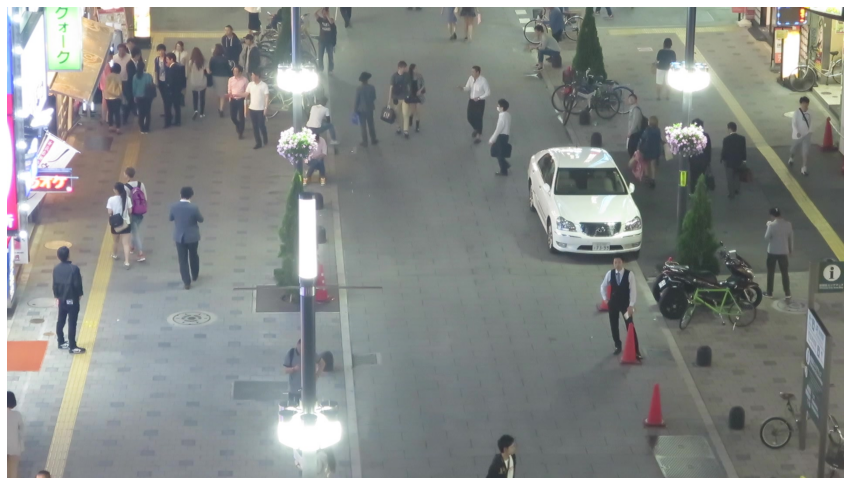

In [ ]:
# Example: detection 하기 전 원본 이미지

import matplotlib
import matplotlib.pylab as plt
import cv2

# motdata3 외의 다른 데이터도 사용할 수 있다. (motdata4,5....)
temp_data = motdata3
list_motdata = os.listdir(temp_data)  
list_motdata.sort()

img_ex_path = temp_data + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,20)) # display the output image
plt.imshow(img_ex)
plt.axis('off')
plt.show()




---


**2. Object Detection with Faster R-CNN**

*  pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.

---




In [ ]:
# Import required packages/modules

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [ ]:
# pretrained Faster R-CNN model을 torchvision에서 받아오기.

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.cuda()
model.eval()
torch.cuda.is_available()

In [ ]:
# class 이름 정의 (출처: PyTorch's official Docs)

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
# model의 prediction 결과를 얻는 함수 정의
# output: 예측된 bounding box와 그에 상응하는 class

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # array를 tensor로 변환시켜주는 transform 정의
  img = transform(img) # array -> tensor
  img = img.cuda()
  pred = model([img]) # model에 image input 넣어주기.
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())] # Prediction class
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].cpu().detach().numpy()) # Prediction confidence score
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Cofidence score가 threshold를 넘는 것만 사용.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]

  return pred_boxes, pred_class

In [ ]:
# 위의 함수를 이용해 여러 image를 한번에 처리하여 이미지로 보여주는 함수 정의

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    x_1, y_1 = boxes[i][0]
    x_2, y_2 = boxes[i][1]
    cv2.rectangle(img, (int(x_1), int(y_1)), (int(x_2), int(y_2)),color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], (int(x_1), int(y_1)),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

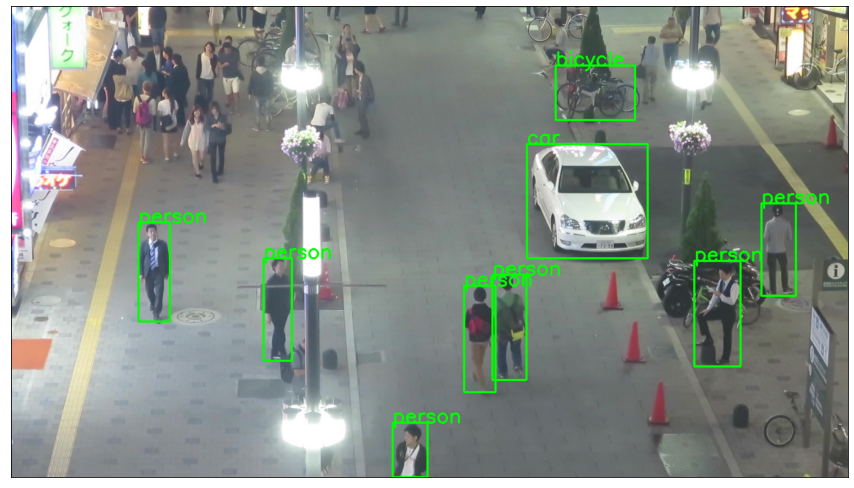

In [ ]:
# Example: detection 결과
temp_data = motdata3
list_motdata = os.listdir(temp_data)

det_path = temp_data + list_motdata[1]
object_detection_api(det_path, threshold=0.99)

threshold 를 바꿔가면서 물체들이 어떻게 검출되는지 확인할 수 있습니다. 



---


**3. Object ID Tracking(Multi Object Tracking) with SORT**


*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking 

---



In [ ]:
# Git clone: SORT Algorithm

!cd "{path}";git clone https://github.com/abewley/sort.git
  
sort_path = join(path,'sort/')
sys.path.append(sort_path)

In [ ]:
# requirement for sort
!cd "{sort_path}";pip install -r requirements.txt

In [ ]:
from pprint import pprint
# del matplotlib
from sort import *

mot_tracker = Sort()      # Tracker using SORT Algorithm

In [ ]:
img_path = motdata    # img root path

# 결과 저장할 위치 생성
save_path = join(path, 'save/')
!mkdir "{save_path}"

In [ ]:
# model의 prediction 결과를 얻는 함수 정의
# output: 예측된 결과

def get_pred(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # array를 tensor로 변환시켜주는 transform 정의
  img = transform(img) # array -> tensor
  img = img.cuda()
  pred = model([img]) # model에 image input 넣어주기.
  return pred 

In [ ]:
from tqdm import tqdm

# 이번에는 motdata2 데이터를 사용. 그 외의 다른 데이터도 사용할 수 있다. (motdata4,5....)
temp_data = motdata2
list_motdata = os.listdir(temp_data)  
list_motdata.sort()

for img_name in tqdm(list_motdata):
    arrlist = []
    img_path = temp_data + img_name
    det_img = cv2.imread(img_path)
    overlay = det_img.copy()
    det_result = get_pred(img_path, 0.5)

    # 예측된 bounding boxes, labels, scores
    bbox = det_result[0]['boxes'].cpu().detach().numpy()
    labels = det_result[0]['labels'].cpu().detach().numpy()
    scores = det_result[0]['scores'].cpu().detach().numpy()

    for (box, label, score) in zip(bbox, labels, scores):
      if label == 1: # 사람 class만 visualizing할 예정 (MS COCO dataset에서는 label 1이 사람)
        arrlist.append(box)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = img_name.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname, det_img)

100%|██████████| 600/600 [02:51<00:00,  3.50it/s]


In [ ]:
import re

path = save_path
paths = [os.path.join(path , i ) for i in os.listdir(path) if re.search(".jpg$", i )]

In [ ]:
pathOut = os.getcwd() + '/out.mp4'
fps = 30

import cv2
frame_array = []
for idx , path in enumerate(paths) : 
    if (idx % 2 == 0) | (idx % 5 == 0) :
        continue
    img = cv2.imread(path)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)

out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    out.write(frame_array[i])
out.release()

In [ ]:
from google.colab import files
files.download('out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>